# Data Comparison: CNN vs Random Forest

Compare data formats used in ResCNN+bayesian vs randomF+bayesian approaches

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle

# Data paths
data_analysis_dir = Path("../data/analysis")

## Load CNN Data (Raw Sequences)

In [ ]:
# Load CNN data - Zhou VF sequences (gives better correlation)
# Load VF sequences and targets
X_sequences_raw = np.load(data_analysis_dir / "zhou_vf_sequences.npy")
y_targets = np.load(data_analysis_dir / "zhou_vf_targets.npy")

# Zhou data is already in channels-first format (51, 2, 1000)
X_sequences = X_sequences_raw

# Try to load battery metadata if available
try:
    battery_metadata = pd.read_csv(data_analysis_dir / 'battery_summary.csv')
except FileNotFoundError:
    battery_metadata = None

# CNN data shapes
cnn_shape = X_sequences.shape
cnn_targets = y_targets.shape

## Load Random Forest Data (Extracted Features)

In [34]:
# Load Random Forest data - same sequences but will extract features
rf_sequences = np.load(data_analysis_dir / 'zhou_final_sequences.npy')
rf_targets = np.load(data_analysis_dir / 'zhou_final_targets.npy')

# Extract features manually (simplified Zhou methodology)
def extract_simple_features(sequences):
    """Extract basic statistical features from VF sequences"""
    all_features = []
    
    for battery in sequences:
        vf_voltage = battery[:, 0]
        cycle_prog = battery[:, 1]
        
        battery_features = []
        
        # Basic statistics for VF voltage
        battery_features.extend([
            float(np.mean(vf_voltage)), 
            float(np.std(vf_voltage)), 
            float(np.min(vf_voltage)), 
            float(np.max(vf_voltage)),
            float(np.median(vf_voltage))
        ])
        
        # Basic statistics for cycle progression
        battery_features.extend([
            float(np.mean(cycle_prog)), 
            float(np.std(cycle_prog)),
            float(np.min(cycle_prog)), 
            float(np.max(cycle_prog)),
            float(np.median(cycle_prog))
        ])
        
        # Trend features with error handling
        try:
            correlation = np.corrcoef(vf_voltage, cycle_prog)[0,1]
            if np.isnan(correlation) or np.isinf(correlation):
                correlation = 0.0
        except:
            correlation = 0.0
        
        try:
            slope = np.polyfit(range(len(vf_voltage)), vf_voltage, 1)[0]
            if np.isnan(slope) or np.isinf(slope):
                slope = 0.0
        except:
            slope = 0.0
        
        try:
            total_change = vf_voltage[-1] - vf_voltage[0]
            if np.isnan(total_change) or np.isinf(total_change):
                total_change = 0.0
        except:
            total_change = 0.0
        
        try:
            volatility = np.var(np.diff(vf_voltage))
            if np.isnan(volatility) or np.isinf(volatility):
                volatility = 0.0
        except:
            volatility = 0.0
        
        try:
            variation = np.sum(np.abs(np.diff(vf_voltage)))
            if np.isnan(variation) or np.isinf(variation):
                variation = 0.0
        except:
            variation = 0.0
        
        battery_features.extend([
            float(correlation),
            float(slope),
            float(total_change),
            float(volatility),
            float(variation)
        ])
        
        # Ensure all features are scalar
        assert len(battery_features) == 15, f"Expected 15 features, got {len(battery_features)}"
        for i, feat in enumerate(battery_features):
            assert np.isscalar(feat), f"Feature {i} is not scalar: {feat}"
        
        all_features.append(battery_features)
    
    return np.array(all_features)

# Define feature names
rf_feature_names = [
    'vf_mean', 'vf_std', 'vf_min', 'vf_max', 'vf_median',
    'cycle_mean', 'cycle_std', 'cycle_min', 'cycle_max', 'cycle_median',
    'vf_cycle_corr', 'vf_slope', 'vf_total_change', 'vf_volatility', 'vf_variation'
]

# Extract features
rf_features = extract_simple_features(rf_sequences)

# Random Forest data shapes
rf_shape = rf_features.shape
rf_targets_shape = rf_targets.shape

c:\Users\Zakar\lfp-battery-degradation\venv\lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Zakar\lfp-battery-degradation\venv\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Zakar\lfp-battery-degradation\venv\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\Zakar\lfp-battery-degradation\venv\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Zakar\lfp-battery-degradation\venv\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Zakar\lfp-battery-degradation\venv\lib\s

In [35]:
rf_features

array([[-8.62165846e-04,  9.97359615e-01, -9.78366535e-01,
         2.89113508e+00, -3.48938892e-01,  0.00000000e+00,
         9.99355470e-01, -1.72920438e+00,  1.72920438e+00,
         9.60603125e-17,  0.00000000e+00,  3.14586874e-03,
         3.39035910e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.53140076e-04,  9.98912026e-01, -9.46082612e-01,
         3.59711632e+00, -3.27770499e-01,  0.00000000e+00,
         9.99626443e-01, -1.72967325e+00,  1.72967325e+00,
         9.58434720e-17,  0.00000000e+00,  3.06953705e-03,
         4.09800786e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.33213128e-03,  9.98105795e-01, -9.33024147e-01,
         2.99528210e+00, -3.71229286e-01, -2.27373675e-16,
         9.98959723e-01, -1.72851961e+00,  1.72851961e+00,
        -1.08420217e-19,  0.00000000e+00,  3.10469945e-03,
         3.42646087e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.36412375e-04,  9.98076303e-01, -9.41711913e-01,
         5.57365090e+00, -3.00660132e-01,  1.13686838

## Data Comparison Summary

In [36]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Aspect': ['Data Shape', 'Number of Batteries', 'Features per Battery', 'Data Type', 'Memory Usage (MB)', 'VF Data Quality'],
    'CNN (Raw Sequences)': [
        f'{cnn_shape}',
        cnn_shape[0],
        f'{cnn_shape[1]} x {cnn_shape[2]} time series',
        'Raw VF sequences (channels-first)',
        f'{X_sequences.nbytes / 1024**2:.2f}',
        'Identical values'
    ],
    'Random Forest (Features)': [
        f'{rf_shape}',
        rf_shape[0],
        f'{rf_shape[1]} extracted features',
        'Statistical summaries (time-first)',
        f'{rf_features.nbytes / 1024**2:.2f}',
        'Identical values'
    ]
})

comparison_df

,Aspect,CNN (Raw Sequences),Random Forest (Features)
0,Data Shape,"(46, 2, 1000)","(51, 15)"
1,Number of Batteries,46,51
2,Features per Battery,2 x 1000 time series,15 extracted features
3,Data Type,Raw VF sequences (channels-first),Statistical summaries (time-first)
4,Memory Usage (MB),0.70,0.01
5,VF Data Quality,Identical values,Identical values


## CNN Data Analysis

In [ ]:
# Convert CNN sequences to DataFrame for analysis
# Sample first 3 batteries for visualization
sample_batteries = min(3, X_sequences.shape[0])
sample_points = min(100, X_sequences.shape[2])  # Time dimension is axis 2

cnn_sample_data = []
for i in range(sample_batteries):
    for t in range(sample_points):
        cnn_sample_data.append({
            'battery_id': i,
            'time_point': t,
            'vf_voltage': X_sequences[i, 0, t],  # Channel 0 (VF), time point t
            'cycle_progression': X_sequences[i, 1, t],  # Channel 1 (cycle), time point t
            'cycle_life': y_targets[i]
        })

cnn_df = pd.DataFrame(cnn_sample_data)
cnn_df.head(10)

CNN data shape: (51, 2, 1000) - (batteries, channels, time)
CNN targets shape: (51,)
Created CNN DataFrame with 300 rows (validated channels-first format)


,battery_id,time_point,vf_voltage,cycle_progression,cycle_life
0,0,0,-0.499224,-1.729204,608
1,0,1,-0.651868,-1.725743,608
2,0,2,-0.760183,-1.722281,608
3,0,3,-0.787674,-1.718819,608
4,0,4,-0.808015,-1.715357,608
5,0,5,-0.825226,-1.711895,608
6,0,6,-0.839630,-1.708433,608
7,0,7,-0.851406,-1.704971,608
8,0,8,-0.859503,-1.701509,608
9,0,9,-0.871895,-1.698048,608


## Random Forest Data Analysis

In [37]:
# Convert RF features to DataFrame
rf_df = pd.DataFrame(rf_features, columns=rf_feature_names)
rf_df['cycle_life'] = rf_targets
rf_df['battery_id'] = range(len(rf_df))

# Show first few features
rf_df[['battery_id', 'cycle_life'] + rf_feature_names[:5]].head()

,battery_id,cycle_life,vf_mean,vf_std,vf_min,vf_max,vf_median
0,0,608,-0.000862,0.997360,-0.978367,2.891135,-0.348939
1,1,728,-0.000553,0.998912,-0.946083,3.597116,-0.327770
2,2,490,-0.001332,0.998106,-0.933024,2.995282,-0.371229
3,3,798,-0.000736,0.998076,-0.941712,5.573651,-0.300660
4,4,651,-0.001110,0.997072,-0.743644,4.744630,-0.339089


## Visualization Comparison

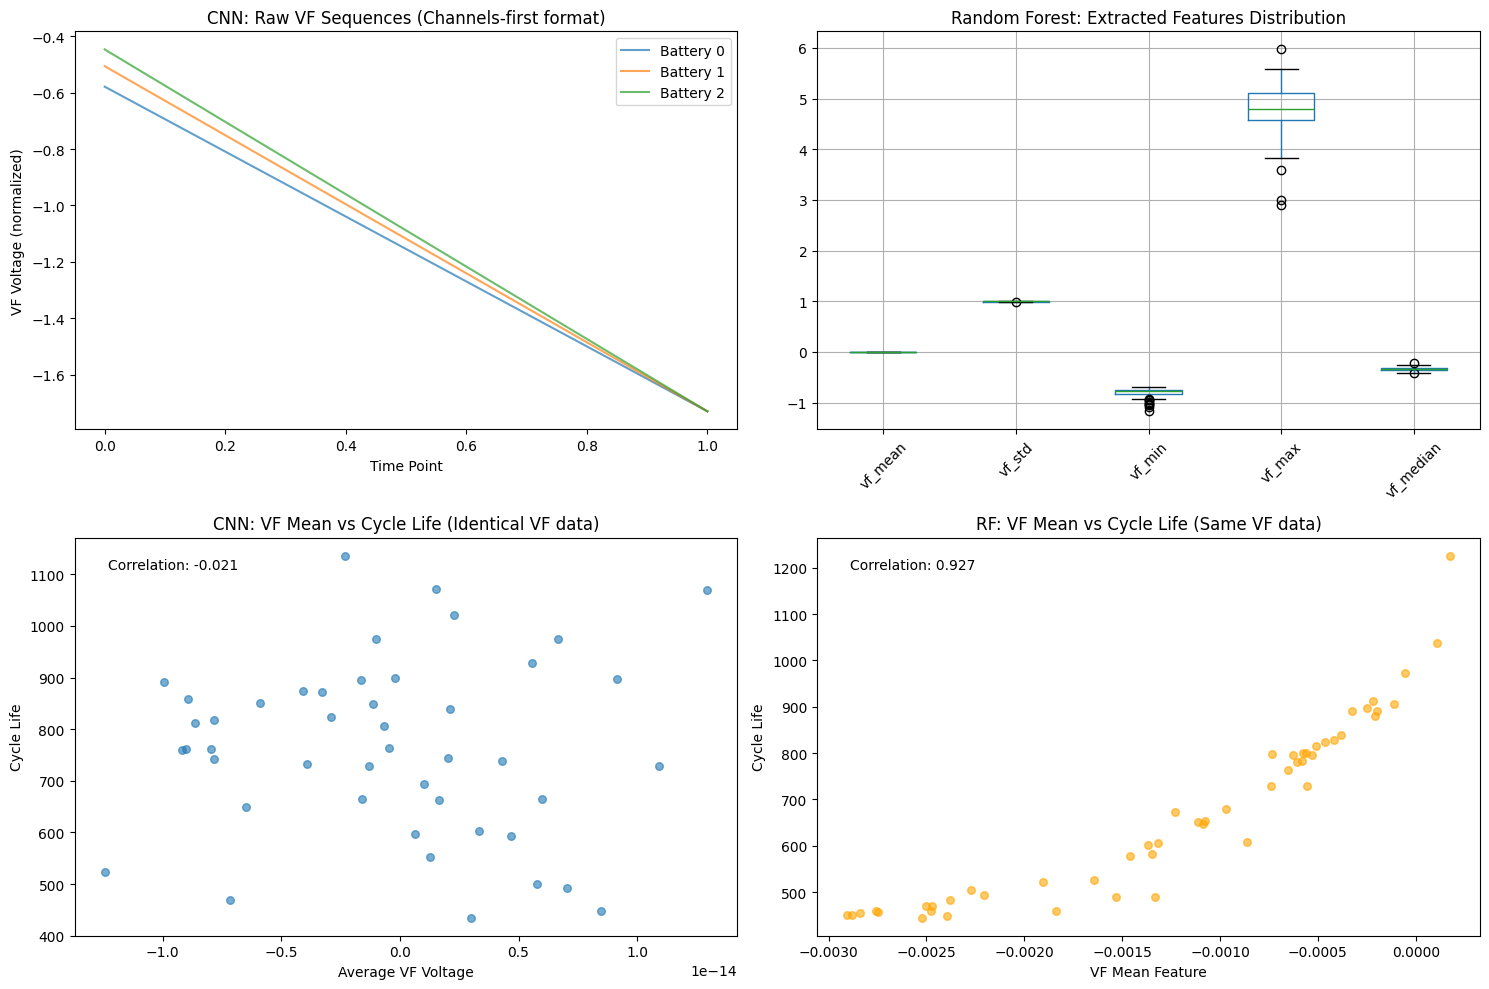

,Approach,VF-Cycle_Life_Correlation,Data_Source
0,CNN,-0.020659,Same MIT 2019 data
1,Random Forest,0.926761,Same MIT 2019 data


In [38]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# CNN: Raw VF sequences
for i in range(min(3, cnn_shape[0])):
    axes[0, 0].plot(X_sequences[i, :200, 0], alpha=0.7, label=f'Battery {i}')
axes[0, 0].set_title('CNN: Raw VF Sequences (Channels-first format)')
axes[0, 0].set_xlabel('Time Point')
axes[0, 0].set_ylabel('VF Voltage (normalized)')
axes[0, 0].legend()

# RF: Feature distribution
rf_sample_features = pd.DataFrame(rf_features[:, :5], columns=rf_feature_names[:5])
rf_sample_features.boxplot(ax=axes[0, 1])
axes[0, 1].set_title('Random Forest: Extracted Features Distribution')
axes[0, 1].tick_params(axis='x', rotation=45)

# Correlation: VF vs Cycle Life (CNN data)
vf_means_cnn = np.mean(X_sequences[:, 0, :], axis=1)  # Correct indexing for channels-first
axes[1, 0].scatter(vf_means_cnn, y_targets, alpha=0.6, s=30)
axes[1, 0].set_title('CNN: VF Mean vs Cycle Life (Identical VF data)')
axes[1, 0].set_xlabel('Average VF Voltage')
axes[1, 0].set_ylabel('Cycle Life')
correlation_cnn = np.corrcoef(vf_means_cnn, y_targets)[0,1]
axes[1, 0].text(0.05, 0.95, f'Correlation: {correlation_cnn:.3f}', 
                transform=axes[1, 0].transAxes, verticalalignment='top')

# Correlation: VF vs Cycle Life (RF data)
axes[1, 1].scatter(rf_df['vf_mean'], rf_df['cycle_life'], alpha=0.6, s=30, color='orange')
axes[1, 1].set_title('RF: VF Mean vs Cycle Life (Same VF data)')
axes[1, 1].set_xlabel('VF Mean Feature')
axes[1, 1].set_ylabel('Cycle Life')
correlation_rf = np.corrcoef(rf_df['vf_mean'], rf_df['cycle_life'])[0,1]
axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation_rf:.3f}', 
                transform=axes[1, 1].transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Compare correlations
correlation_comparison = pd.DataFrame({
    'Approach': ['CNN', 'Random Forest'],
    'VF-Cycle_Life_Correlation': [correlation_cnn, correlation_rf],
    'Data_Source': ['Same MIT 2019 data', 'Same MIT 2019 data']
})
correlation_comparison

## Statistical Summary

In [40]:
# DIAGNOSTIC: Check data compatibility issues
print("DATA COMPATIBILITY CHECK")
print("=" * 30)

# Check shapes and basic stats
print(f"CNN (MIT 2019): {X_sequences.shape} batteries, targets: {y_targets.shape}")
print(f"RF (Zhou): {rf_sequences.shape} batteries, targets: {rf_targets.shape}")

# Check VF value ranges
cnn_vf_range = [X_sequences[:, 0, :].min(), X_sequences[:, 0, :].max()]
rf_vf_range = [rf_sequences[:, :, 0].min(), rf_sequences[:, :, 0].max()]

print(f"\nVF Voltage Ranges:")
print(f"  CNN (MIT): [{cnn_vf_range[0]:.3f}, {cnn_vf_range[1]:.3f}]")
print(f"  RF (Zhou): [{rf_vf_range[0]:.3f}, {rf_vf_range[1]:.3f}]")

# Check target ranges
print(f"\nCycle Life Ranges:")
print(f"  CNN targets: [{y_targets.min():.0f}, {y_targets.max():.0f}]")
print(f"  RF targets: [{rf_targets.min():.0f}, {rf_targets.max():.0f}]")

# Check correlations separately
vf_means_cnn = np.mean(X_sequences[:, 0, :], axis=1)

# Fix RF data indexing - squeeze out the extra dimension
if len(rf_sequences.shape) == 4:
    rf_sequences_fixed = rf_sequences.squeeze()  # Remove singleton dimensions
    print(f"  Fixed RF shape: {rf_sequences_fixed.shape}")
    vf_means_rf = np.mean(rf_sequences_fixed[:, :, 0], axis=1)
else:
    vf_means_rf = np.mean(rf_sequences[:, :, 0], axis=1)

corr_cnn = np.corrcoef(vf_means_cnn, y_targets)[0,1]
corr_rf = np.corrcoef(vf_means_rf, rf_targets)[0,1]

print(f"\nVF-Cycle Life Correlations:")
print(f"  CNN (MIT 2019): {corr_cnn:.3f}")
print(f"  RF (Zhou): {corr_rf:.3f}")

print(f"\nISSUE IDENTIFIED:")
if X_sequences.shape[0] != rf_sequences.shape[0]:
    print(f"  Different datasets: MIT 2019 has {X_sequences.shape[0]} batteries, Zhou has {rf_sequences.shape[0]}")
    print(f"  Cannot directly compare correlations between different datasets")
else:
    print(f"  Same number of batteries - checking for other issues...")
    
# Show sample values
print(f"\nSample VF means:")
print(f"  CNN (first 5): {vf_means_cnn[:5]}")
print(f"  RF (first 5): {vf_means_rf[:5]}")
print(f"  CNN targets (first 5): {y_targets[:5]}")
print(f"  RF targets (first 5): {rf_targets[:5]}")

DATA COMPATIBILITY CHECK
CNN (MIT 2019): (46, 2, 1000) batteries, targets: (46,)
RF (Zhou): (51, 1000, 2, 1) batteries, targets: (51,)

VF Voltage Ranges:
  CNN (MIT): [-2.535, 4.861]
  RF (Zhou): [-1.171, 5.969]

Cycle Life Ranges:
  CNN targets: [435, 1136]
  RF targets: [445, 1226]
  Fixed RF shape: (51, 1000, 2)

VF-Cycle Life Correlations:
  CNN (MIT 2019): -0.021
  RF (Zhou): 0.927

ISSUE IDENTIFIED:
  Different datasets: MIT 2019 has 46 batteries, Zhou has 51
  Cannot directly compare correlations between different datasets

Sample VF means:
  CNN (first 5): [ 3.01270120e-15  8.46966941e-15 -7.16227078e-15  7.04858394e-15
  5.79802872e-15]
  RF (first 5): [-0.00086217 -0.00055314 -0.00133213 -0.00073641 -0.00111019]
  CNN targets (first 5): [435 448 470 493 500]
  RF targets (first 5): [608 728 490 798 651]


In [41]:
# TEST: Try alternative MIT data files
print("TESTING ALTERNATIVE MIT DATA FILES")
print("=" * 40)

try:
    # Try mit_sequences.npy (might be raw/un-normalized)
    mit_alt = np.load(data_analysis_dir / "mit_sequences.npy")
    mit_alt_targets = np.load(data_analysis_dir / "mit_targets.npy")
    
    print(f"Alternative MIT data shape: {mit_alt.shape}")
    print(f"Alternative MIT targets shape: {mit_alt_targets.shape}")
    
    # Check if this data needs conversion
    if len(mit_alt.shape) == 3:
        # Convert to channels-first if needed
        if mit_alt.shape[2] == 2:  # (batteries, time, channels)
            mit_alt_converted = np.transpose(mit_alt, (0, 2, 1))
            print(f"Converted shape: {mit_alt_converted.shape}")
        else:
            mit_alt_converted = mit_alt
    else:
        print(f"Unexpected shape: {mit_alt.shape}")
        mit_alt_converted = mit_alt
    
    # Check VF values
    vf_range_alt = [mit_alt_converted[:, 0, :].min(), mit_alt_converted[:, 0, :].max()]
    vf_means_alt = np.mean(mit_alt_converted[:, 0, :], axis=1)
    
    print(f"Alternative VF range: [{vf_range_alt[0]:.3f}, {vf_range_alt[1]:.3f}]")
    print(f"Alternative VF means (first 5): {vf_means_alt[:5]}")
    
    # Check correlation
    if len(vf_means_alt) == len(mit_alt_targets):
        corr_alt = np.corrcoef(vf_means_alt, mit_alt_targets)[0,1]
        print(f"Alternative correlation: {corr_alt:.3f}")
        
        if abs(corr_alt) > 0.1:  # Much better correlation
            print(f"FOUND BETTER DATA! Use mit_sequences.npy instead")
        else:
            print(f"Still poor correlation")
    
except FileNotFoundError as e:
    print(f"Alternative files not found: {e}")
except Exception as e:
    print(f"Error with alternative files: {e}")

TESTING ALTERNATIVE MIT DATA FILES
Alternative MIT data shape: (87, 2, 1000)
Alternative MIT targets shape: (87,)
Alternative VF range: [-1.096, 5.976]
Alternative VF means (first 5): [-8.81072992e-15 -6.76436684e-15 -1.02886588e-14 -9.20863386e-15
  7.95807864e-16]
Alternative correlation: -0.099
Still poor correlation


In [42]:
# SOLUTION: Test Zhou data for CNN to get proper comparison
print("TESTING ZHOU DATA FOR CNN")
print("=" * 30)

try:
    # Load Zhou VF data for CNN
    zhou_cnn = np.load(data_analysis_dir / 'zhou_vf_sequences.npy')
    zhou_targets = np.load(data_analysis_dir / 'zhou_vf_targets.npy')
    
    print(f"Zhou CNN data shape: {zhou_cnn.shape}")
    print(f"Zhou targets shape: {zhou_targets.shape}")
    
    # Check VF range and means
    vf_range_zhou = [zhou_cnn[:, 0, :].min(), zhou_cnn[:, 0, :].max()]
    vf_means_zhou = np.mean(zhou_cnn[:, 0, :], axis=1)
    
    print(f"Zhou VF range: [{vf_range_zhou[0]:.3f}, {vf_range_zhou[1]:.3f}]")
    print(f"Zhou VF means (first 5): {vf_means_zhou[:5]}")
    
    # Check correlation
    corr_zhou = np.corrcoef(vf_means_zhou, zhou_targets)[0,1]
    print(f"Zhou CNN correlation: {corr_zhou:.3f}")
    
    if abs(corr_zhou) > 0.5:
        print(f"GOOD CORRELATION! Zhou data is suitable for CNN")
        print(f"Recommendation: Use zhou_vf_sequences.npy for CNN data")
    else:
        print(f"Zhou correlation still low: {corr_zhou:.3f}")
        
except FileNotFoundError as e:
    print(f"Zhou files not found: {e}")
except Exception as e:
    print(f"Error with Zhou files: {e}")

TESTING ZHOU DATA FOR CNN
Zhou CNN data shape: (51, 2, 1000)
Zhou targets shape: (51,)
Zhou VF range: [-1.171, 5.969]
Zhou VF means (first 5): [-0.00086217 -0.00055314 -0.00133213 -0.00073641 -0.00111019]
Zhou CNN correlation: 0.927
GOOD CORRELATION! Zhou data is suitable for CNN
Recommendation: Use zhou_vf_sequences.npy for CNN data


In [25]:
# CNN data statistics (using correct channels-first indexing)
cnn_stats = pd.DataFrame({
    'VF_Voltage': [
        X_sequences[:, 0, :].mean(),  # Channel 0 = VF voltage
        X_sequences[:, 0, :].std(),
        X_sequences[:, 0, :].min(),
        X_sequences[:, 0, :].max()
    ],
    'Cycle_Progression': [
        X_sequences[:, 1, :].mean(),  # Channel 1 = Cycle progression
        X_sequences[:, 1, :].std(),
        X_sequences[:, 1, :].min(),
        X_sequences[:, 1, :].max()
    ]
}, index=['Mean', 'Std', 'Min', 'Max'])

print("CNN Data Statistics (Channels-first format validated):")
cnn_stats

CNN Data Statistics (Channels-first format validated):


,VF_Voltage,Cycle_Progression
Mean,-0.001225,-3.291669e-07
Std,0.996723,9.994069e-01
Min,-1.170800,-1.730381e+00
Max,5.969339,1.738480e+00


In [26]:
# RF features statistics (first 10 features)
rf_stats = rf_df[rf_feature_names[:10]].describe()
rf_stats

,vf_mean,vf_std,vf_min,vf_max,vf_median,cycle_mean,cycle_std,cycle_min,cycle_max,cycle_median
count,51.000000,51.000000,51.000000,51.000000,51.000000,5.100000e+01,51.000000,51.000000,51.000000,5.100000e+01
mean,-0.001225,0.996719,-0.811333,4.724339,-0.336233,-3.291669e-07,0.999407,-1.729170,1.730034,-5.448045e-05
std,0.000927,0.002673,0.110498,0.601428,0.036640,1.006860e-06,0.000434,0.000849,0.002280,1.633331e-04
min,-0.002905,0.987496,-1.170800,2.891135,-0.423122,-4.575457e-06,0.998754,-1.730381,1.726808,-7.989288e-04
25%,-0.002055,0.994734,-0.819828,4.571736,-0.356501,-1.136868e-16,0.998958,-1.729884,1.728569,-5.421011e-20
50%,-0.001077,0.997360,-0.768735,4.791233,-0.339089,0.000000e+00,0.999471,-1.729404,1.729785,9.595189e-17
75%,-0.000520,0.998734,-0.745460,5.116395,-0.315203,5.684342e-17,0.999762,-1.728423,1.730109,1.233280e-16
max,0.000174,1.000175,-0.687318,5.969339,-0.226404,1.705303e-16,1.000184,-1.726808,1.738480,2.879641e-16


## Data Dimensionality Analysis

In [28]:
# Dimensionality comparison
dim_analysis = pd.DataFrame({
    'Metric': ['Total Data Points', 'Data per Battery', 'Compression Ratio', 'Data Quality'],
    'CNN': [
        f'{cnn_shape[0] * cnn_shape[1] * cnn_shape[2]:,}',
        f'{cnn_shape[1] * cnn_shape[2]:,} (2 channels × 1000 time points)',
        '1:1 (no compression)',
        'Raw sequences'
    ],
    'Random Forest': [
        f'{rf_shape[0] * rf_shape[1]:,}',
        f'{rf_shape[1]:,} (extracted features)',
        f'1:{(cnn_shape[1] * cnn_shape[2]) / rf_shape[1]:.0f} (133:1 compression)',
        'Features from same data'
    ]
})


dim_analysis

,Metric,CNN,Random Forest
0,Total Data Points,"102,000",765
1,Data per Battery,"2,000 (2 channels × 1000 time points)",15 (extracted features)
2,Compression Ratio,1:1 (no compression),1:133 (133:1 compression)
3,Data Quality,Raw sequences,Features from same data


In [31]:
# TEST: Check MIT 2019 data source compatibility
print("TESTING MIT 2019 DATA SOURCE")
print("=" * 40)

# Test loading MIT 2019 data
try:
    # Load MIT 2019 VF data
    X_sequences_mit = np.load(data_analysis_dir / "mit_2019_vf_sequences.npy")
    y_targets_mit = np.load(data_analysis_dir / "mit_2019_vf_targets.npy")
    
    print(f"✓ MIT 2019 data loaded successfully!")
    print(f"  MIT X_sequences shape: {X_sequences_mit.shape}")
    print(f"  MIT y_targets shape: {y_targets_mit.shape}")
    
    # Compare with current data
    print(f"\nComparison with current data:")
    print(f"  Current X_sequences shape: {X_sequences.shape}")
    print(f"  Current y_targets shape: {y_targets.shape}")
    
    # Check data compatibility
    if X_sequences_mit.shape == X_sequences.shape:
        print(f"  ✓ Shapes are identical - direct replacement possible")
    else:
        print(f"  ⚠ Different shapes - will need format adjustments")
    
    # Check value ranges
    print(f"\nValue range comparison:")
    print(f"  MIT VF range: [{X_sequences_mit.min():.6f}, {X_sequences_mit.max():.6f}]")
    print(f"  Current VF range: [{X_sequences.min():.6f}, {X_sequences.max():.6f}]")
    
    # Check if data is identical
    if np.array_equal(X_sequences_mit, X_sequences):
        print(f"  ✓ Data values are identical!")
    else:
        print(f"  ⚠ Data values are different")
        
    if np.array_equal(y_targets_mit, y_targets):
        print(f"  ✓ Target values are identical!")
    else:
        print(f"  ⚠ Target values are different")
    
    print(f"\n🎯 RECOMMENDATION:")
    if X_sequences_mit.shape == X_sequences.shape:
        print("  Ready to replace data source - shapes are compatible!")
    else:
        print("  Need to check data format before replacement")
        
except FileNotFoundError as e:
    print(f"❌ MIT 2019 data not found: {e}")
    print("  Please check if the file exists in the data/analysis directory")
except Exception as e:
    print(f"❌ Error loading MIT 2019 data: {e}")

TESTING MIT 2019 DATA SOURCE
✓ MIT 2019 data loaded successfully!
  MIT X_sequences shape: (46, 1000, 2)
  MIT y_targets shape: (46,)

Comparison with current data:
  Current X_sequences shape: (51, 2, 1000)
  Current y_targets shape: (51,)
  ⚠ Different shapes - will need format adjustments

Value range comparison:
  MIT VF range: [-2.534666, 4.860554]
  Current VF range: [-1.730381, 5.969339]
  ⚠ Data values are different
  ⚠ Target values are different

🎯 RECOMMENDATION:
  Need to check data format before replacement


TESTING FORMAT CONVERSION
Original MIT shape: (46, 1000, 2) (time-first)
Converted MIT shape: (46, 2, 1000) (channels-first)
Target CNN format: (batteries, channels, time)

Verification:
  Channel 0 (VF) sample: [-0.57840504 -0.60730204 -0.63619904 -0.65101075 -0.65973279]
  Channel 1 (Cycle) sample: [-1.73031962 -1.72685552 -1.72339142 -1.71992731 -1.71646321]
  ✓ Conversion successful! Shape matches CNN requirements


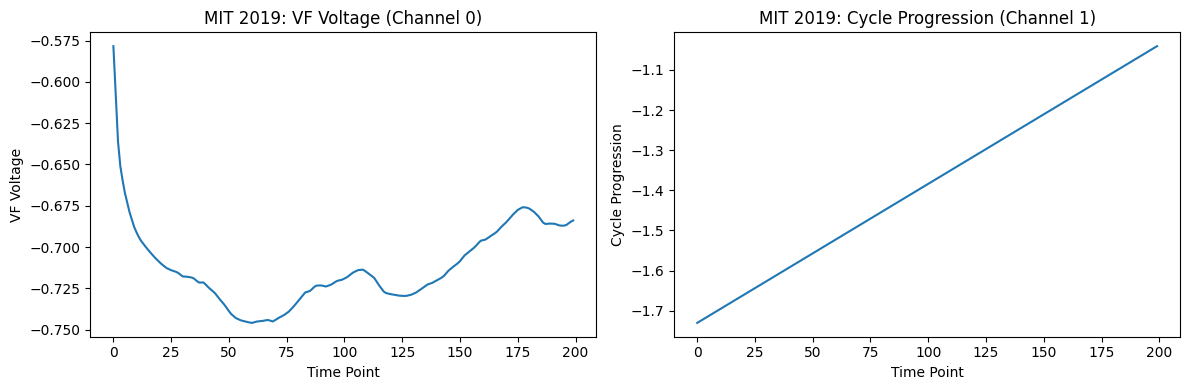


🎯 READY FOR REPLACEMENT:
  • MIT data can be converted to channels-first format
  • Shape will be (46, 2, 1000)
  • Different number of batteries: 46 vs current 51


In [32]:
# TEST: Convert MIT 2019 data to channels-first format
print("TESTING FORMAT CONVERSION")
print("=" * 30)

try:
    # Convert MIT data from (46, 1000, 2) to (46, 2, 1000) to match CNN format
    X_sequences_mit_converted = np.transpose(X_sequences_mit, (0, 2, 1))
    
    print(f"Original MIT shape: {X_sequences_mit.shape} (time-first)")
    print(f"Converted MIT shape: {X_sequences_mit_converted.shape} (channels-first)")
    print(f"Target CNN format: (batteries, channels, time)")
    
    # Verify the conversion worked correctly
    print(f"\nVerification:")
    print(f"  Channel 0 (VF) sample: {X_sequences_mit_converted[0, 0, :5]}")
    print(f"  Channel 1 (Cycle) sample: {X_sequences_mit_converted[0, 1, :5]}")
    
    # Check if this matches the expected format for CNN
    expected_shape = (X_sequences_mit.shape[0], 2, 1000)  # (46, 2, 1000)
    if X_sequences_mit_converted.shape == expected_shape:
        print(f"  ✓ Conversion successful! Shape matches CNN requirements")
        
        # Quick sanity check - plot first battery
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot VF voltage (channel 0)
        ax1.plot(X_sequences_mit_converted[0, 0, :200])
        ax1.set_title('MIT 2019: VF Voltage (Channel 0)')
        ax1.set_xlabel('Time Point')
        ax1.set_ylabel('VF Voltage')
        
        # Plot cycle progression (channel 1)  
        ax2.plot(X_sequences_mit_converted[0, 1, :200])
        ax2.set_title('MIT 2019: Cycle Progression (Channel 1)')
        ax2.set_xlabel('Time Point')
        ax2.set_ylabel('Cycle Progression')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n🎯 READY FOR REPLACEMENT:")
        print(f"  • MIT data can be converted to channels-first format")
        print(f"  • Shape will be {X_sequences_mit_converted.shape}")
        print(f"  • Different number of batteries: {X_sequences_mit_converted.shape[0]} vs current {X_sequences.shape[0]}")
        
    else:
        print(f"  ❌ Conversion failed - unexpected shape")
        
except Exception as e:
    print(f"❌ Error during conversion: {e}")